In [259]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import plotly
from skimage import io
from skimage import morphology as morp
import plotly.express as px
import plotly.graph_objects as go

# **Linear Algebra & Image Compression**

1. Download India Flag image.
2. Convert it to grayscale and
3. Open and display that image
4. Print the dimensions of the image
5. Compute the number of integers required to store this image

In [0]:
base_url = '/content/drive/My Drive/CVIT_WORKSHOP_2020/day8'
url = base_url + '/images'

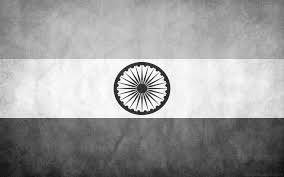

(177, 284)
no of bytes: 50268


In [272]:
M = cv2.imread(url + '/indian_flag.jpeg', cv2.IMREAD_GRAYSCALE)
cv2_imshow(M)
print(M.shape)
original_bytes = M.shape[0] * M.shape[1]
print('no of bytes: ' + str(original_bytes))

1. Apply SVD on the image to get U, D, V_T.
2. Note how the D matrix is returned. You may need to use other numpy functions to convert to required form of D
3. Using U, D, V_T reconstruct back the image by matrix multiplication and display the image

(177,)
(177, 177)
(177, 177)
(177, 284)


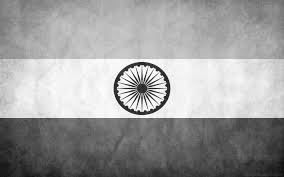

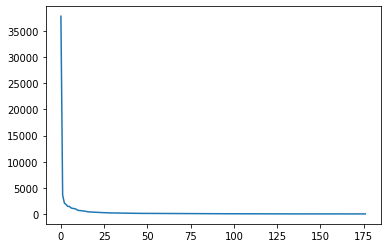

In [273]:
U, D, Vt = np.linalg.svd(M, full_matrices=False)
print(D.shape)
plt.plot(D)
d = np.diag(D)
print(U.shape)
print(d.shape)
print(Vt.shape)
N = np.matmul(np.matmul(U, d), Vt)
np.isclose(M, N).all()
cv2_imshow(N)

1. Keep a variable 'component'.
2. Use only the first 'component' singular values/vectors from U,D,V_T
3. Reconstruct using 10 components

(177, 10)
(10,)
(10, 284)


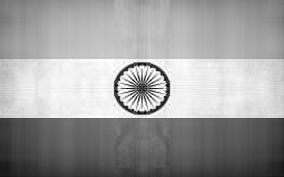

In [274]:
components = 10

Uc = U[:, :components]
Dc = D[:components]
Vtc = Vt[:components, :]
dc = np.diag(Dc)
Nc = Uc @ dc @ Vtc
print(Uc.shape)
print(Dc.shape)
print(Vtc.shape)
new_bytes = Uc.shape[0]*Uc.shape[1]+Dc.shape[0]+Vtc.shape[0]*Vtc.shape[1]

cv2_imshow(Nc)

In [275]:
compression_ratio = original_bytes / new_bytes
print('compression ratio: ' + str(compression_ratio))

compression ratio: 10.88051948051948


In [276]:
print("Information preserved: " + str(sum(Dc) / sum(D)))

Information preserved: 0.791410618748355


# **Unsupervised Learning**

In [0]:
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import cm

In [0]:
def plot_clusters(points, cluster_labels, offset=0.01, show_annotation=True):
  cluster_labels = np.array(cluster_labels)
  un_clusters = np.unique(cluster_labels)

  if len(points.shape)==1 or points.shape[1]==1:
    points = np.hstack((points.ravel()[:, None], np.zeros(points.shape[0])[:, None]))

  cluster_labels = np.array(cluster_labels)
  points = np.array(points)

  for cluster in un_clusters:
    if (cluster_labels == cluster).any():
      plt.scatter(points[cluster_labels == cluster, 0], points[cluster_labels == cluster, 1], label=cluster)

  if show_annotation:
    for i in range(points.shape[0]):
      plt.annotate(i, (points[i,0]+offset, points[i,1]+offset))

  plt.legend()

In [0]:
np.random.seed(2)
points = np.vstack((np.random.normal(0,0.5,size=(4,2)),np.random.normal(3,0.5,size=(4,2))))
points = np.vstack((points, np.array([[1.5,1.5]])))
points = np.vstack((points, np.array([[1.25,1.25]])))

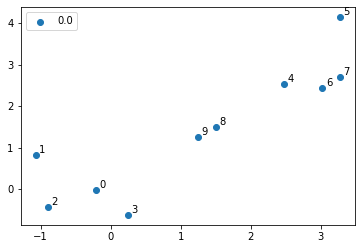

In [279]:
cluster_labels = np.zeros((10)).tolist()
offset = 0.05

plot_clusters(points, cluster_labels, offset)
plt.show()

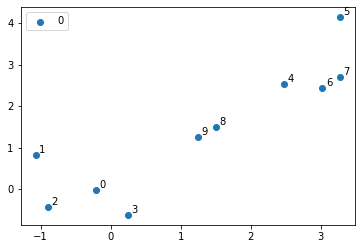

q


In [281]:
cluster_labels = np.zeros((10), dtype=np.int32).tolist()
offset = 0.05

plot_clusters(points, cluster_labels, offset)
plt.show()
while(True):
  ip = input()
  if ip == 'q':
    break
  
  idx, label = [i.strip() for i in ip.split('-')]
  idx = int(idx)

  cluster_labels[idx] = label
  if label not in un_clusters:
    un_clusters.append(label)
  
  plot_clusters(points, cluster_labels, offset)
  plt.show()

In [0]:
def heatmap(grid, xlabels, ylabels, xrot=90):   
    cmap = cm.get_cmap("viridis")
    plt.imshow(grid, cmap=cmap)
    plt.xticks(np.arange(0,grid.shape[1],step=1), xlabels, rotation=xrot)
    plt.yticks(np.arange(0, grid.shape[0], step=1), ylabels)

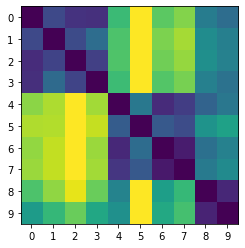

In [292]:
grid = euclidean_distances(points, points)
grid = (grid - grid.min(axis=1)[:,None])/(grid.max(axis=1)[:,None]-grid.min(axis=1)[:,None])

xlabels = np.arange(0,points.shape[0])
ylabels = np.arange(0,points.shape[0])
heatmap(grid, xlabels, ylabels, xrot=0)

## **What if we take distances of every point from only 3 other points?**

Let's select 3 random points and find the distances of all the points from these 3 points.

In [0]:
K = 3
means = np.random.uniform(0,3,size=(K,2))

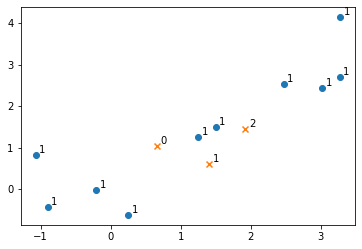

In [297]:
offset=0.05
plt.scatter(points[:,0], points[:,1], marker='o')
for i in range(points.shape[0]):
  plt.annotate(1, (points[i, 0]+offset, points[i,1]+offset))
plt.scatter(means[:,0], means[:,1], marker='x')
for i in range(means.shape[0]):
  plt.annotate(i, (means[i,0]+offset, means[i,1]+offset))

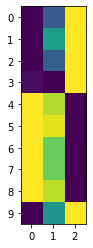

In [298]:
grid = euclidean_distances(points, means)

grid = (grid - grid.min(axis=1)[:,None])/(grid.max(axis=1)[:,None]-grid.min(axis=1)[:,None])
xlabels = np.arange(0,means.shape[0])
ylabels = np.arange(0,points.shape[0])
heatmap(grid, xlabels, ylabels, xrot=0)

In [0]:
def initialise(points, K):
  # take random k points from the dataset
  cluster_centers = points[np.random.choice(points.shape[0], K, replace=False)]
  return cluster_centers

In [0]:
cluster_centers = initialise(points, 3)

In [0]:
def assign(points, cluster_centers):
  # Tie breaking uniformly
  dist = euclidean_distances(points, cluster_centers)
  cluster_labels = np.argmin(dist, axis=1)
  return cluster_labels

In [320]:
np.random.seed(2)
cluster_centers = np.array([[0,0], [1,1], [2,2]])
cluster_labels = assign(points, cluster_centers)
cluster_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [0]:
def recalculate_cluster_centers(points, cluster_labels, K):
  cluster_centers = np.zeros((K, points.shape[1]))
  for label in range(K):
    cluster_centers[label, :] = points[cluster_labels==label, :].mean(axis=0)
  return cluster_centers

In [322]:
recalculate_cluster_centers(points, cluster_labels, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning:

invalid value encountered in true_divide



array([[       nan,        nan],
       [0.90756139, 1.05568158],
       [7.68226994, 7.62044   ]])

In [0]:
def KMeans(points, K):
  cluster_labels = np.zeros((points.shape[0]))

  # initialise K cluster centers
  cluster_centers = initialise(points, K)

  initial_centers = cluster_centers.copy()
  old_cluster_centers = np.zeros(cluster_centers.shape)

  while not (old_cluster_centers==cluster_centers).all():
    old_cluster_centers = cluster_centers.copy()
    
    # assign
    cluster_labels = assign(points, cluster_centers)

    # recalculate
    custer_centers = recalculate_cluster_centers(points, cluster_labels, K)

  return cluster_labels, initial_centers, cluster_centers

In [324]:
KMeans(points, 3)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([[16.24143963, 16.49742565],
        [ 1.83227341,  1.94706844],
        [ 3.45865236,  3.64541663]]),
 array([[16.24143963, 16.49742565],
        [ 1.83227341,  1.94706844],
        [ 3.45865236,  3.64541663]]))

## **Initialize dataset**

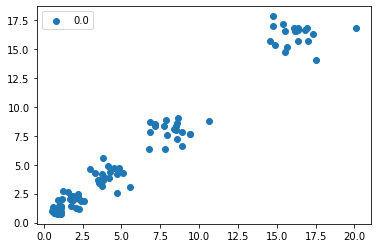

In [342]:
np.random.seed(2)
K = 5
X = []
for i in range(5):
    X.append(np.random.normal(2**i,(i+1)/5, size=(20,2)))

points = np.vstack(X)
plot_clusters(points, np.zeros((points.shape[0])), show_annotation=False)

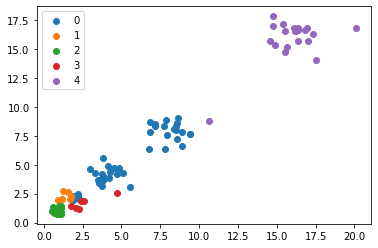

In [343]:
cluster_labels, initial_centers, final_centers = KMeans(points, K)
plot_clusters(points, cluster_labels, show_annotation=False)

### **Task 1**

Run the kmeans multiple times and see if averaging the cluster centers across runs
helps to reduce dependency on initialisation. Here the assumption is that good clustering is
more likely than bad one. Dataset: The 5 clusters.

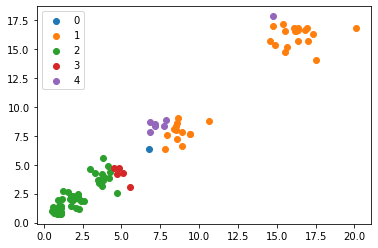

In [349]:
iter = 10
cluster_centers = np.zeros((K, points.shape[1]))
for _ in range(iter):
  cluster_labels, _, final_centers = KMeans(points, K)
  cluster_centers += final_centers
cluster_centers /= iter
cluster_labels = assign(points, cluster_centers)
plot_clusters(points, cluster_labels, show_annotation=False)

### **Result**

Averaging centers multiple times is not giving good results

### **Task 2**

Run the algorithm on concentric circles dataset in r-theta space or some other space
you like.

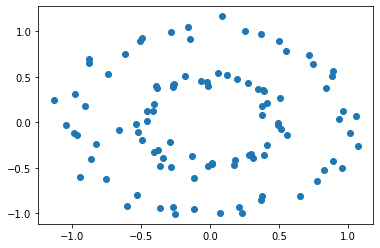

In [350]:
from sklearn.datasets.samples_generator import make_circles

points, _ = make_circles(100, noise=0.06, factor=0.5)
plt.scatter(points[:, 0], points[:, 1])

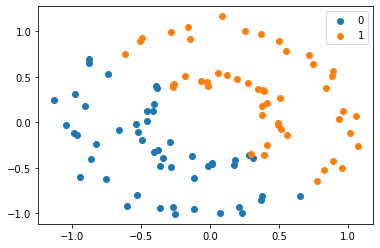

In [352]:
K = 2
cluster_labels, initial_centers, final_centers = KMeans(points, K)
plot_clusters(points, cluster_labels, show_annotation=False)

In [0]:
from sklearn import preprocessing

polar_points = np.zeros(points.shape)
polar_points[:, 0] = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
polar_points[:, 1] = np.arctan2(points[:, 1], points[:, 0])

# polar_points[:, 0] = preprocessing.normalize(polar_points[:, 0:1]).ravel()
# polar_points = preprocessing.normalize(polar_points)

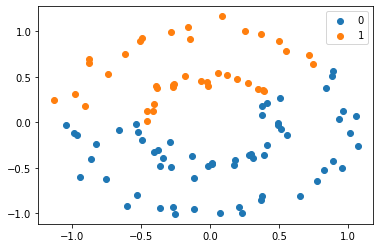

In [386]:
K = 2
cluster_labels, initial_centers, final_centers = KMeans(polar_points, K)
plot_clusters(points, cluster_labels, show_annotation=False)

 ### **Task 3**

You need to install pandas and use python3

1. Download and run the script.py file and the tmdb_5000_movies.csv file from the link
below and put them in the same folder.
2. Run script.py using python3 in the same folder as the tmdb_5000_movies.csv.
3. Select a movie preference out of the 5 that are shown. Do this till you have 30 movies at
least.
4. A final.json file will be generated in the folder from which you ran script.py
a. Rename final.json to final_<yourname>.json
b. Put this file in the Final Datasets folder in the link below
5. Download the data after 7PM today and try clustering based on various movie
preferences.

In [0]:
url1 = base_url + '/Dataset Folder'
url2 = url1 + '/Final Dataset'

name = 'akshat'

In [389]:
import pandas as pd
import json, os

df = pd.read_csv(url1 + "/tmdb_5000_movies.csv")

data = {}
num_choices = 5

try:
    with open(url2 + "/final_" + name + ".json", "r") as f:
        data = json.load(f)
except:
    ip = input("Enter your name: ").strip()
    while ip == "":
        ip = input("Enter your name: ")
        
    data["username"] = ip
    data["movie_ids"] = []
    data["genre_freq"] = {}
    data["genre_freq_divided"] = {}
    
    for i in range(df.shape[0]):
        genres = json.loads(df["genres"].iloc[i])
        for genre in genres:
            data["genre_freq"][genre["name"]] = 0
            data["genre_freq_divided"][genre["name"]] = 0
            
while len(data["movie_ids"]) != df.shape[0]:
    num_idxs = min(df.shape[0]-len(data["movie_ids"]), num_choices)
    idxs = np.random.choice(df.shape[0], size=num_idxs, replace=False)
    
    print("-"*100)
    for i,idx in enumerate(idxs.tolist()):
        while df["id"].iloc[idx] in data["movie_ids"]: 
            idx = np.random.randint(0, df.shape[0])

        print("{}) {}".format(i, df["title"].iloc[idx]))

    ip = np.random.randint(low=0, high=5, size=1)[0]
    # ip = int(input("Preferred Movie: "))
    if not 0<=ip<num_choices:
        print("No option selected. Skipping...")
        continue
    
    chosen_loc = idxs[i]
    genres = json.loads(df["genres"].iloc[chosen_loc])
    for genre in genres:
        data["genre_freq"][genre["name"]] += 1
        data["genre_freq_divided"][genre["name"]] += 1/len(genres)

    data["movie_ids"].append(int(df["id"].iloc[chosen_loc]))

    with open(url2 + "/final_" + name + ".json", "w") as f:
        json.dump(data, f)

Streaming output truncated to the last 5000 lines.
0) The Deep End of the Ocean
1) The Players Club
2) Scooby-Doo 2: Monsters Unleashed
3) Charlie's Angels: Full Throttle
4) Little Women
----------------------------------------------------------------------------------------------------
0) Chernobyl Diaries
1) Run, Hide, Die
2) Perrier’s Bounty
3) Born on the Fourth of July
4) Mighty Joe Young
----------------------------------------------------------------------------------------------------
0) The Exorcism of Emily Rose
1) Friday the 13th Part VII: The New Blood
2) Batman & Robin
3) The Oogieloves in the Big Balloon Adventure
4) Sleep Tight
----------------------------------------------------------------------------------------------------
0) Nowhere to Run
1) Crouching Tiger, Hidden Dragon
2) Along the Roadside
3) Bodyguards and Assassins
4) The Transporter
----------------------------------------------------------------------------------------------------
0) Jason X
1) The Rock
2) 

In [438]:
import pandas as pd
import os

K = 5
names = []
dataset = []

try:
  with open(url2 + "/final_" + name + ".json", "r") as f:
    data = json.load(f)['genre_freq_divided']
  genres = np.array(list(data.keys()))
  for filename in os.listdir(url2):
    if filename.endswith(".json"): 
      file = os.path.join(url2, filename)
      with open(file, "r") as f:
        data = json.load(f)
      names.append(data['username'])
      genre_freq_divided = []
      for genre in genres:
        if genre in data['genre_freq_divided']:
          genre_freq_divided.append(data['genre_freq_divided'][genre])
        else:
          genre_freq_divided.append(0)
      dataset.append(genre_freq_divided)
  names = np.array(names)
  dataset = np.array(dataset)
  data_labels, _, _ = KMeans(dataset, K)
  for i in range(names.shape[0]):
    print(names[i], data_labels[i])
except:
  print('error')

Sai Shashank 4
yoogottamk 2
dolton 4
ttirth 1
Ayan 2
Ammar 3
abhishek 3
Aman 0
varun 1
aryamaan 2
Avani 0
Kalyan 0
Akshat 0
